In [171]:
from IPython.display import display
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO 
from subprocess import call

import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import tree
from sklearn.tree import export_graphviz

import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize, sent_tokenize
np.random.seed(0)
warnings.filterwarnings('ignore')
from sklearn.utils.testing import all_estimators

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
mercari_df = pd.read_csv("train.tsv", sep = '\t')
mercari_df.shape
mercari_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


# Data Cleaning

In [3]:
# Check the Feature Type and Null Value
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [4]:
mercari_df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [5]:
# From the table above
# 0) No need to touch [Train_id] and [name] 
# 1) [item_condition_id] ???
# 2) [Category_name] has also roughly 6,300 of null values
# 3) [Brand_name] has 632,682 of null values
# 4) [Price] is my target-variable
# 5) [shipping] ???
# 6) 4 of non-value for [Item-description]

1) item_condition_id

In [6]:
mercari_df['item_condition_id'].value_counts()

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

2) Category_name: has roughly 6,300 of null values and I need to split catergories.

In [7]:
mercari_df["category_name"].value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Handmade/Pets/Tag                                     1
Handmade/Pets/Blanket                                 1
Handmade/Patterns/Accessories                         1
Handmade/Bags and Purses/Other                        1
Handmade/Furniture/Other                              1
Name: category_name, Length: 1287, dtype: int64

In [8]:
# Split the Category and remove null-values
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']

In [9]:
mercari_df['cat_Big'], mercari_df['cat_Med'],mercari_df['cat_Small'] = \
                        zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

In [10]:
print(mercari_df['cat_Big'].value_counts())
print(mercari_df['cat_Big'].nunique())

Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_Big, dtype: int64
11


In [11]:
print(mercari_df['cat_Med'].value_counts())
print(mercari_df['cat_Med'].nunique())

Athletic Apparel        134383
Makeup                  124624
Tops & Blouses          106960
Shoes                   100452
Jewelry                  61763
                         ...  
Candles                     64
Ceramics and Pottery        57
Dolls and Miniatures        49
Books and Zines             46
Quilts                      31
Name: cat_Med, Length: 114, dtype: int64
114


In [12]:
print(mercari_df['cat_Small'].value_counts())
print(mercari_df['cat_Small'].nunique())

Pants, Tights, Leggings    60177
Other                      50224
Face                       50171
T-Shirts                   46380
Shoes                      32168
                           ...  
Seasonal                       1
Storage Solutions              1
Doorstops                      1
Entertainment                  1
Bathroom Shelves               1
Name: cat_Small, Length: 871, dtype: int64
871


In [13]:
mercari_df['category_name'] = mercari_df['category_name'].fillna(value = 'Other_Null')

Now, Category_name is cleaned and removed the null_values.

3) Brand_name: has almost half of null values

In [14]:
mercari_df['brand_name'].value_counts()

PINK                 54088
Nike                 54043
Victoria's Secret    48036
LuLaRoe              31024
Apple                17322
                     ...  
Silkland                 1
Perfection               1
Brioni                   1
Veronica Beard           1
Truly Scrumptious        1
Name: brand_name, Length: 4809, dtype: int64

In [15]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value = 'Other_Null')

4) Price : my target-variable

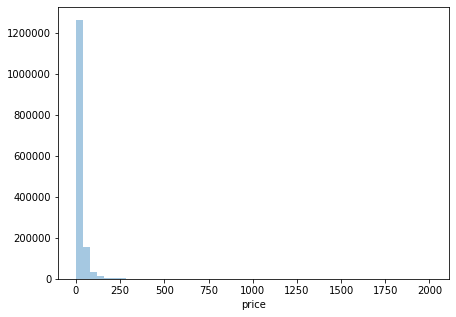

In [16]:
y_train_df = mercari_df.price
plt.figure(figsize=(7,5))
sns.distplot(y_train_df, kde=False)

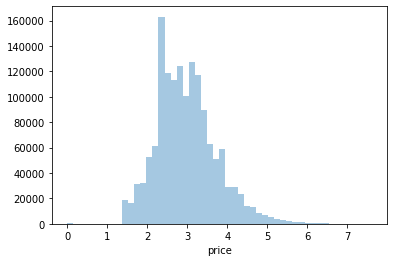

In [17]:
# Now, it looks like normal distribution now
y_train_df= np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

In [18]:
mercari_df.price = np.log1p(mercari_df.price)
mercari_df.price.head()

0    2.397895
1    3.970292
2    2.397895
3    3.583519
4    3.806662
Name: price, dtype: float64

5) [shipping] 

In [19]:
mercari_df.shipping.value_counts()

0    819435
1    663100
Name: shipping, dtype: int64

6) Item-description : Delete 4 of 'non-value' and 'No decription yet'

In [20]:
mercari_df["item_description"].value_counts()

No description yet                                                                                                                                                                                                                                                                                                                                    82489
New                                                                                                                                                                                                                                                                                                                                                    4099
Brand new                                                                                                                                                                                                                                                                                                       

In [21]:
mercari_df["item_description"].value_counts()

No description yet                                                                                                                                                                                                                                                                                                                                    82489
New                                                                                                                                                                                                                                                                                                                                                    4099
Brand new                                                                                                                                                                                                                                                                                                       

In [22]:
mercari_df["item_description"] = mercari_df["item_description"].fillna(value = 'Other_Null')

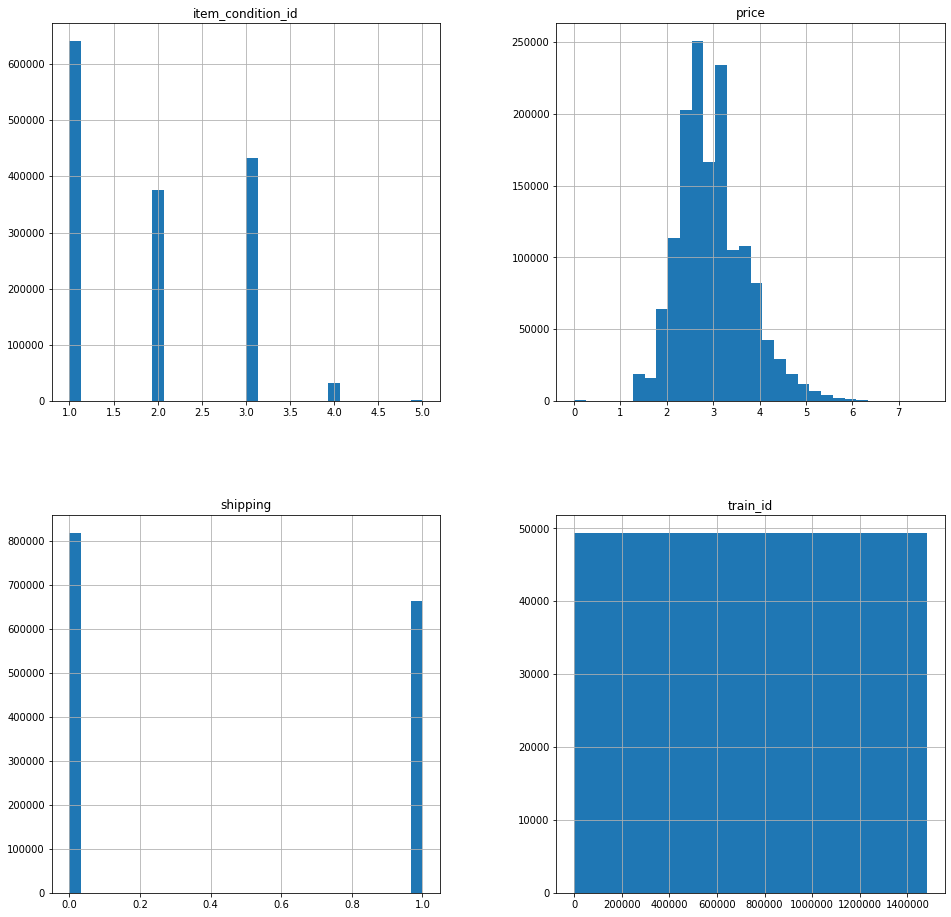

In [23]:
mercari_df.hist(bins=30, figsize=(16,16))
plt.show()

In [24]:
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_Big              0
cat_Med              0
cat_Small            0
dtype: int64

In [25]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 11 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1482535 non-null object
brand_name           1482535 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482535 non-null object
cat_Big              1482535 non-null object
cat_Med              1482535 non-null object
cat_Small            1482535 non-null object
dtypes: float64(1), int64(3), object(7)
memory usage: 124.4+ MB


# Feature Encoding/Feature Vectorisation

In [26]:
#Token/Stopwords/ Stem or Lemma
# One Hot coding / LabelBinarizer
# count Vector (Short words: names)
# TD-IDF (Long words : Item_description)

In [27]:
mercari_df['brand_name'].nunique()


4810

In [28]:
b1 = mercari_df['brand_name'].value_counts()
b1.head()

Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64

Vectorisation

In [61]:
df_item = mercari_df["item_description"]

In [62]:
df_item.head()

0                                   No description yet
1    This keyboard is in great condition and works ...
2    Adorable top with a hint of lace and a key hol...
3    New with tags. Leather horses. Retail for [rm]...
4            Complete with certificate of authenticity
Name: item_description, dtype: object

In [78]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet') 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [152]:
def clean_item(item):
    cleaned_item = []
    for line in item:
        if not '[' in line and  not ']' in line:
            for symbol in ';-`'","':'"&.?!)''(\n":
                line = line.replace(symbol, '').lower()
            cleaned_item.append(line)

    return cleaned_item

item_without_brackets = clean_item(mercari_df["item_description"])
item_without_brackets

['no description yet',
 'this keyboard is in great condition and works like it came out of the box all of the ports are tested and work perfectly the lights are customizable via the razer synapse app on your pc',
 'adorable top with a hint of lace and a key hole in the back the pale pink is a 1x and i also have a 3x available in white',
 'complete with certificate of authenticity',
 'banana republic bottoms candies skirt with matching blazeramy byers suit loft bottoms and cami top',
 'size small but straps slightly shortened to fit xs besides that perfect condition',
 'girls size small plus green three shorts total',
 'i realized his pants are on backwards after the picture they were very dirty so i hand washed them he has a stuffed body and painted porcelain head hands and feet back before clowns were too scary 9" tall no chips or cracks but minor paint loss in a few places clown circus doll collectible',
 '5 new vs pink body mists 25 oz each fresh  clean sun kiss cool and bright tota

In [153]:
def tokenize(item):
    joined_item = ' '.join(item)
    tokenized_item = word_tokenize(joined_item)
    
    return tokenized_item

tokenized_test_item = tokenize(item_without_brackets)
print(tokenized_test_item)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [154]:
print(tokenized_test_item[:3])

['no', 'description', 'yet']


In [155]:
fdist = FreqDist(tokenized_test_item)
print(fdist)

<FreqDist with 298451 samples and 30698774 outcomes>


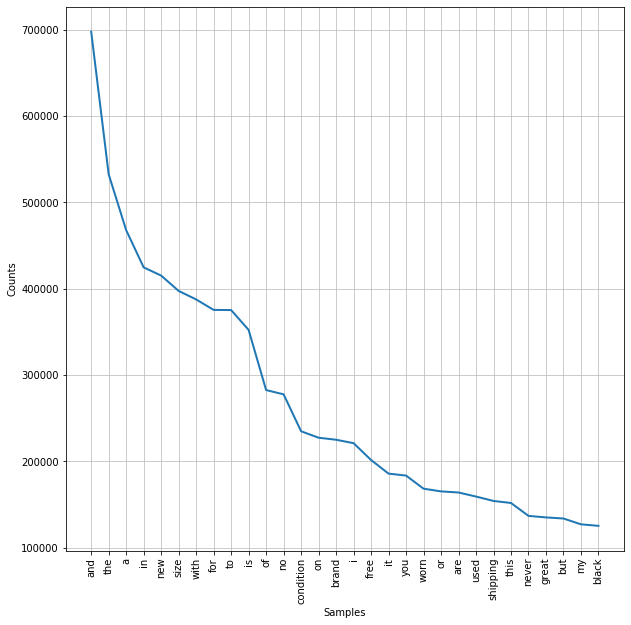

In [156]:
plt.figure(figsize=(10,10))
fdist.plot(30)

In [157]:
stop_words=set(stopwords.words("english"))
print(stop_words)

{'now', 'are', 'our', 'aren', 're', 'hasn', 'ours', 'shan', 'll', 'which', "weren't", 'were', 'all', 'from', 'yourself', 'theirs', "that'll", 'wouldn', 'further', 'out', 'he', 'few', 'mustn', 'because', 'hadn', 'no', "you've", 'isn', 'than', 's', 'd', 'how', 'o', 'don', 'it', 'then', 'haven', 'with', 'each', "wasn't", 'should', 'shouldn', 'when', 'was', 'we', 'she', "it's", 'did', 'while', 'a', 'above', 'there', 'why', "doesn't", "hasn't", 'his', 'other', "won't", 'these', 'only', 'your', 'up', 'been', 'or', 'm', 'again', 'here', 'i', 'where', 'can', 'an', 'be', 'during', 'below', 'do', 'to', 'some', 'its', 'before', 'so', 'himself', 'very', 'my', "you'll", 'weren', 'those', 'their', 't', 'couldn', 'wasn', 'her', 'into', 'ourselves', 'hers', 'that', 'who', "couldn't", "isn't", 'themselves', 'under', 'through', 'mightn', "should've", 'yours', 'doing', 'by', 'between', 'same', "mightn't", 'after', "shouldn't", "you'd", "haven't", 'herself', 'y', "aren't", "mustn't", 'him', 'both', 'havin

In [158]:
filtered_review=[]
for w in tokenized_test_item:
    if w not in stop_words:
        filtered_review.append(w)
print("Filterd Sentence:",filtered_review)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [159]:
print(len(tokenized_test_item))
print(len(filtered_review))

30698774
21818168


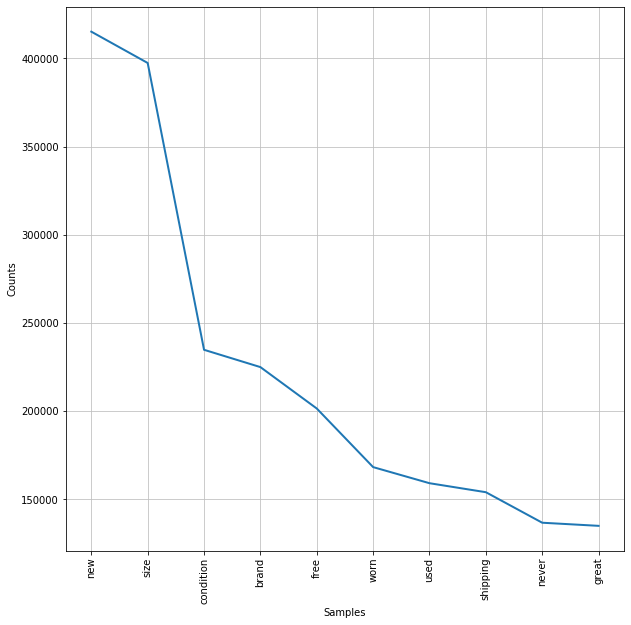

In [160]:
fdist = FreqDist(filtered_review)
plt.figure(figsize=(10,10))
fdist.plot(10)

In [161]:
#Lemmatization
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

In [162]:
# we can also lemmatize our original reviews
lemmatized_review=[]
for w in filtered_review:
    lemmatized_review.append(lemmatizer.lemmatize(w))

print(lemmatized_review)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



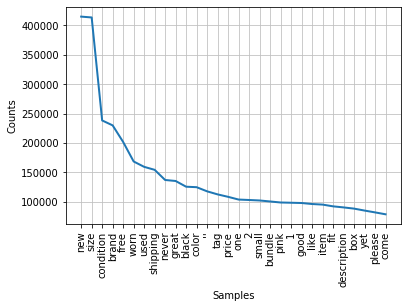

In [163]:
fdist = FreqDist(lemmatized_review)
fdist.plot(30)

# Feature Vectorisation (Name: Countvector, Item_Desc : TfidfVector)

In [164]:
from sklearn.feature_extraction.text import CountVectorizer
cnt_vec = CountVectorizer()
x_name = cnt_vec.fit_transform(mercari_df.name)

In [165]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range = (1,3), stop_words ='english')
x_descp = tfidf_descp.fit_transform(lemmatized_review)

In [166]:
type(x_descp)
x_descp.shape

(21818168, 50000)

In [167]:
type(x_name)
x_name.shape

(1482535, 105757)

In [168]:
from sklearn.preprocessing import LabelBinarizer

#onehotencoding for brand_name, item_condtion, shipping

lb_brandname=LabelBinarizer(sparse_output=True)
x_brand=lb_brandname.fit_transform(mercari_df['brand_name'])
lb_itemcond=LabelBinarizer(sparse_output=True)
x_itemcond=lb_itemcond.fit_transform(mercari_df['item_condition_id'])
lb_shipping=LabelBinarizer(sparse_output=True)
x_shipping=lb_shipping.fit_transform(mercari_df['shipping'])

In [169]:
lb_cat_Big=LabelBinarizer(sparse_output=True)
x_cat_Big=lb_cat_Big.fit_transform(mercari_df['cat_Big'])
lb_cat_Medium=LabelBinarizer(sparse_output=True)
x_cat_Medium=lb_cat_Medium.fit_transform(mercari_df['cat_Med'])
lb_cat_Small=LabelBinarizer(sparse_output=True)
x_cat_Small=lb_cat_Small.fit_transform(mercari_df['cat_Small'])

In [170]:
from scipy.sparse import hstack
sparse_matrix_list = (x_name, x_descp,x_brand,x_itemcond,x_shipping, lb_cat_Big, lb_cat_Medium, lb_cat_Small)

x_features_sparse =hstack(sparse_matrix_list).toscr()


ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 21818168, expected 1482535.

In [ ]:
print(types(x_features_sparse),x_features_sparse.shape)